# Manifold GP Trivial Learning via Precision Matrix on 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

## Dataset Preprocessing

### Load

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

normalize_features = False
normalize_labels = True

### Noise

In [3]:
noise_sampled_x = 0.0
noisy_x = sampled_x + noise_sampled_x * torch.randn(m, n)

noise_sampled_y = 0.01
noisy_y = sampled_y + noise_sampled_y * torch.randn(m)

### Normalize

In [4]:
if normalize_features:
    mu_x, std_x = noisy_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    noisy_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = noisy_y.mean(), noisy_y.std()
    noisy_y.sub_(mu_y).div_(std_y)

### Move Data to Device

In [5]:
noisy_x, noisy_y = noisy_x.contiguous(), noisy_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
noisy_x, noisy_y = noisy_x.to(device), noisy_y.to(device)

## Model

In [6]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=1,
        nodes=noisy_x,
        neighbors=10,
        operator="randomwalk",
        modes=100,
        ball_scale=1.0,
        support_kernel=gpytorch.kernels.RBFKernel(),
        epsilon_prior=None,  # GammaPrior(gamma_concentration, gamma_rate),
        lengthscale_prior=None  # InverseGammaPrior(igamma_concentration, igamma_rate)
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(noisy_x, noisy_y, likelihood, kernel).to(device)

hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.0037,
    'covar_module.base_kernel.lengthscale': 3.0644,
    'covar_module.outputscale': 1.0,
    'covar_module.base_kernel.support_kernel.lengthscale': 1.0,
}
model.initialize(**hypers)

## Train

In [7]:
model.manifold_informed_train(lr=1e-1, iter=100, verbose=True)

tensor(1., device='cuda:0', grad_fn=<SoftplusBackward0>)
Iter: 0, LR: 0.100, Loss: -1286.454, NoiseVar: 0.010, SignalVar: 12691.120, Lengthscale: 3.064, Epsilon: 0.004
Iter: 1, LR: 0.100, Loss: -1279.840, NoiseVar: 0.009, SignalVar: 12691.021, Lengthscale: 2.969, Epsilon: 0.004
Iter: 2, LR: 0.100, Loss: -1313.717, NoiseVar: 0.008, SignalVar: 12690.921, Lengthscale: 2.875, Epsilon: 0.004
Iter: 3, LR: 0.100, Loss: -1298.673, NoiseVar: 0.007, SignalVar: 12690.821, Lengthscale: 2.780, Epsilon: 0.004
Iter: 4, LR: 0.100, Loss: -1342.383, NoiseVar: 0.007, SignalVar: 12690.722, Lengthscale: 2.686, Epsilon: 0.004
Iter: 5, LR: 0.100, Loss: -1301.632, NoiseVar: 0.006, SignalVar: 12690.622, Lengthscale: 2.594, Epsilon: 0.004
Iter: 6, LR: 0.100, Loss: -1318.492, NoiseVar: 0.006, SignalVar: 12690.521, Lengthscale: 2.501, Epsilon: 0.004
Iter: 7, LR: 0.100, Loss: -1329.045, NoiseVar: 0.005, SignalVar: 12690.421, Lengthscale: 2.409, Epsilon: 0.004
Iter: 8, LR: 0.100, Loss: -1317.553, NoiseVar: 0.005, S

Iter: 76, LR: 0.100, Loss: -1339.285, NoiseVar: 0.000, SignalVar: 12683.489, Lengthscale: 0.088, Epsilon: 0.004
Iter: 77, LR: 0.100, Loss: -1360.569, NoiseVar: 0.000, SignalVar: 12683.390, Lengthscale: 0.090, Epsilon: 0.004
Iter: 78, LR: 0.100, Loss: -1381.221, NoiseVar: 0.000, SignalVar: 12683.290, Lengthscale: 0.091, Epsilon: 0.004
Iter: 79, LR: 0.100, Loss: -1358.618, NoiseVar: 0.000, SignalVar: 12683.190, Lengthscale: 0.093, Epsilon: 0.004
Iter: 80, LR: 0.100, Loss: -1361.902, NoiseVar: 0.000, SignalVar: 12683.091, Lengthscale: 0.095, Epsilon: 0.004
Iter: 81, LR: 0.100, Loss: -1380.925, NoiseVar: 0.000, SignalVar: 12682.991, Lengthscale: 0.096, Epsilon: 0.004
Iter: 82, LR: 0.100, Loss: -1370.355, NoiseVar: 0.000, SignalVar: 12682.892, Lengthscale: 0.097, Epsilon: 0.004
Iter: 83, LR: 0.100, Loss: -1384.101, NoiseVar: 0.000, SignalVar: 12682.792, Lengthscale: 0.097, Epsilon: 0.004
Iter: 84, LR: 0.100, Loss: -1353.508, NoiseVar: 0.000, SignalVar: 12682.692, Lengthscale: 0.097, Epsilon

In [8]:
likelihood.noise

tensor([0.0002], device='cuda:0', grad_fn=<AddBackward0>)

## Evaluation

In [9]:
%%capture
likelihood.eval()
model.eval()

## Metrics

In [10]:
from manifold_gp.models.riemann_gp import ScaleWrapper, NoiseWrapper

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cg_iterations(10000):
#     preds_manifold = model(noisy_x)
    preds_manifold = likelihood(model(noisy_x))
    posterior_mean_manifold = preds_manifold.mean
        
    error = noisy_y - posterior_mean_manifold
    rmse = error.square().sum().sqrt()/m
    
    covar = preds_manifold.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/m
    
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.0006, device='cuda:0')
NLL:  tensor(-2.2823, device='cuda:0')


/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


## Plot

In [11]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-1.5, 1.5, resolution), torch.linspace(-1.5, 1.5, resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        preds_ambient = model(grid_x.sub(mu_x).div(std_x))
        noisy_x.mul_(std_x).add_(mu_x)
    else:
        preds_ambient = model(grid_x)

### Ground Truth

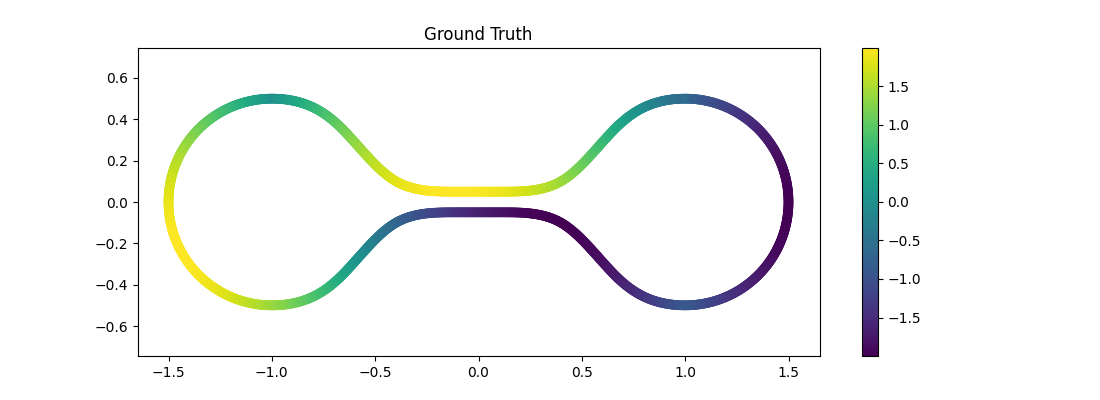

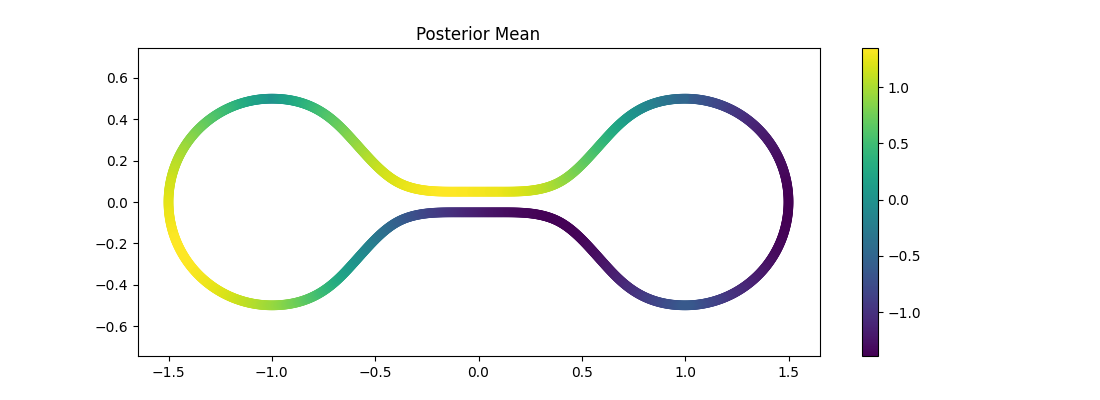

In [25]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=sampled_y.cpu().numpy())  # vmin=-0.5, vmax=0.5
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Ground Truth')
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold.cpu().numpy())
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

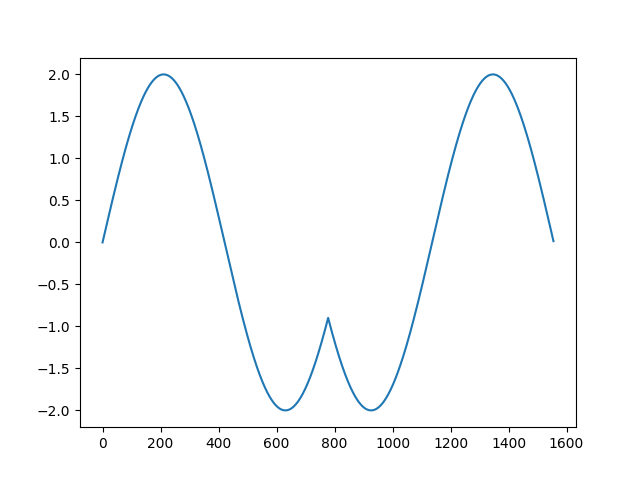

In [13]:
idx_ordered = np.array([edges[0,0],edges[0,1]])
tmp = np.delete(edges, 0, axis=0)
while idx_ordered.shape[0] != m:
    idx_next = np.where(np.any(tmp == idx_ordered[-1], axis=1))
    idx_ordered = np.append(idx_ordered,tmp[idx_next][0][0 if tmp[idx_next][0][1]==idx_ordered[-1] else 1])
    tmp = np.delete(tmp, idx_next, axis=0)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(m), truth[idx_ordered])

### Posterior Mean

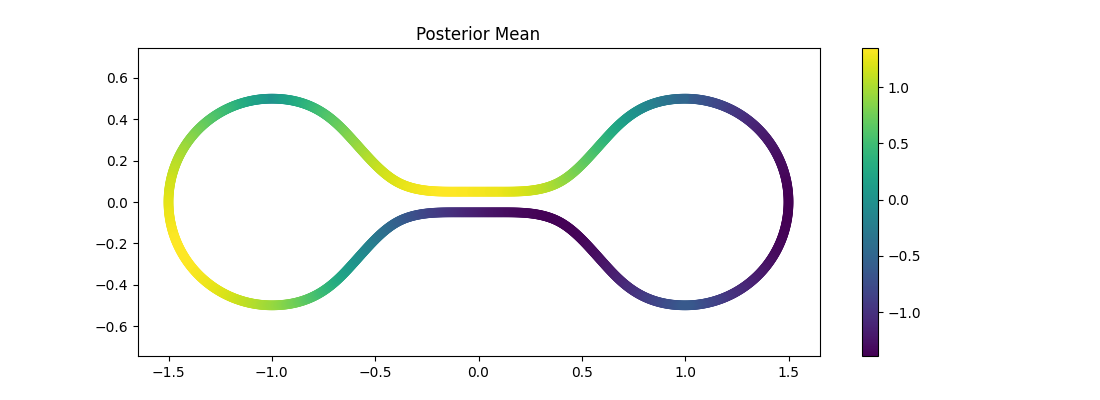

In [14]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold.cpu().numpy())
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

### Kernel Evaluation

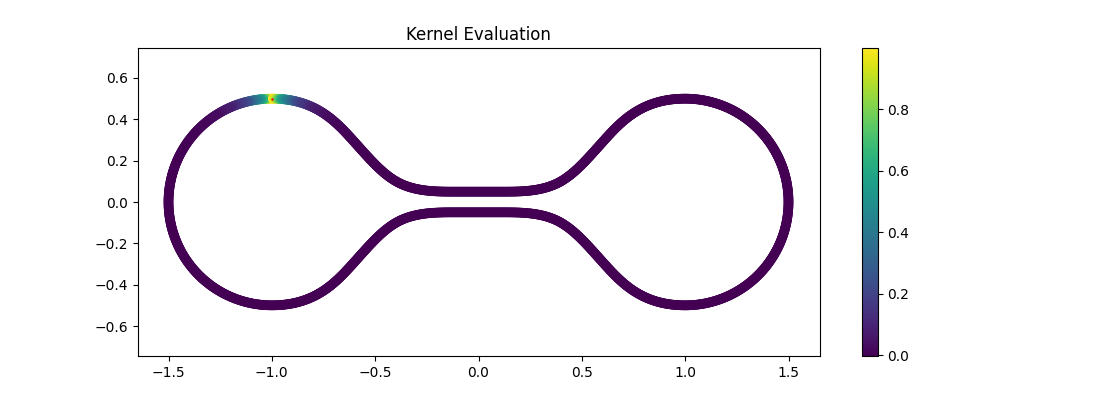

In [15]:
with torch.no_grad():
    k_base = kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x[0, :].unsqueeze(0)).evaluate()
    kernel_eval_manifold = (kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x).evaluate()/k_base).squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=kernel_eval_manifold)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Features

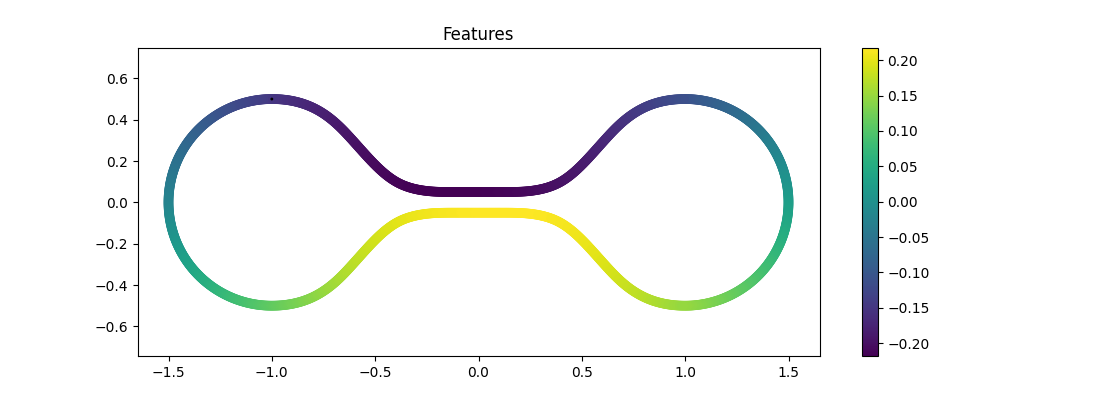

In [16]:
with torch.no_grad():
    c = 1.0
    l_features = kernel.base_kernel.features(noisy_x, c=c)[:,1].cpu().numpy()
    e_features = kernel.base_kernel.eigenvectors[:,1].cpu().numpy()
    f_features = kernel.base_kernel.base_feature._featurize(noisy_x)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=l_features)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
    ax.add_patch(circle)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Features')

### Prior Variance

In [17]:
model.covar_module.outputscale

tensor(0.7937, device='cuda:0', grad_fn=<SoftplusBackward0>)

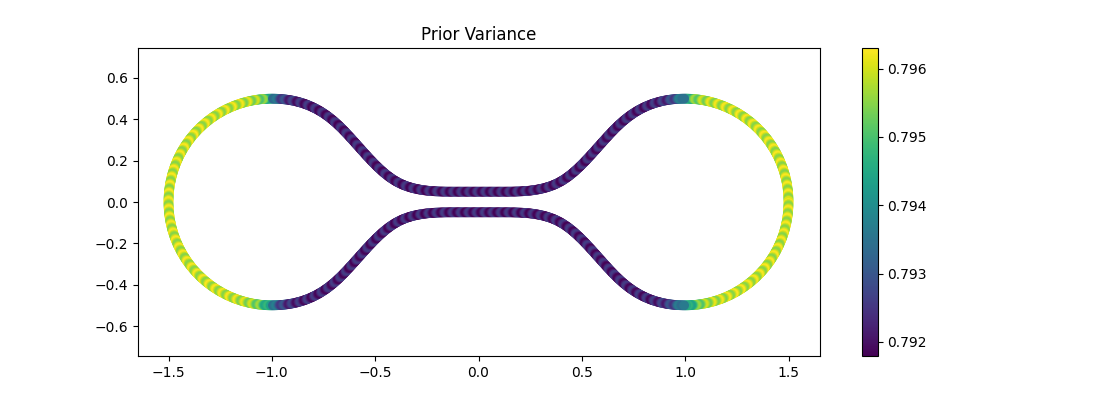

In [18]:
with torch.no_grad():
    prior_var_manifold = model.covar_module(noisy_x, noisy_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=prior_var_manifold)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Variance')

### Posterior Standard Deviation

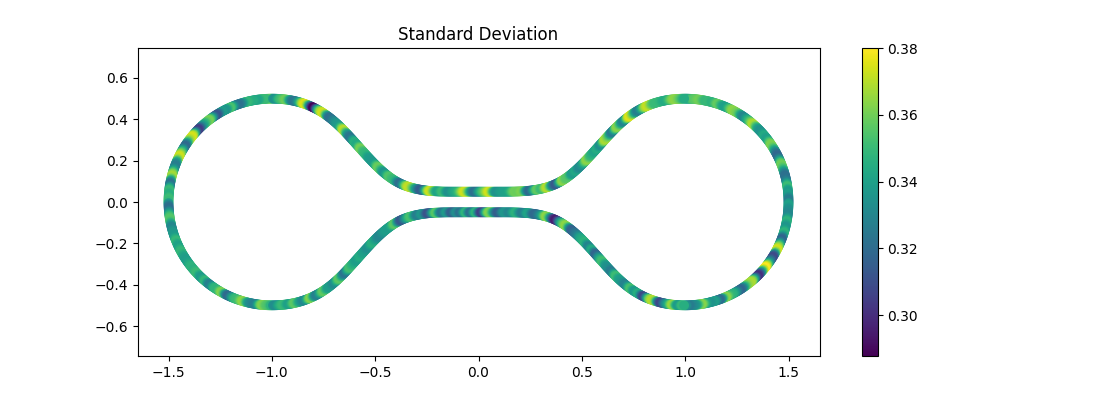

In [19]:
with torch.no_grad():
    posterior_std_manifold = preds_manifold.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_std_manifold)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

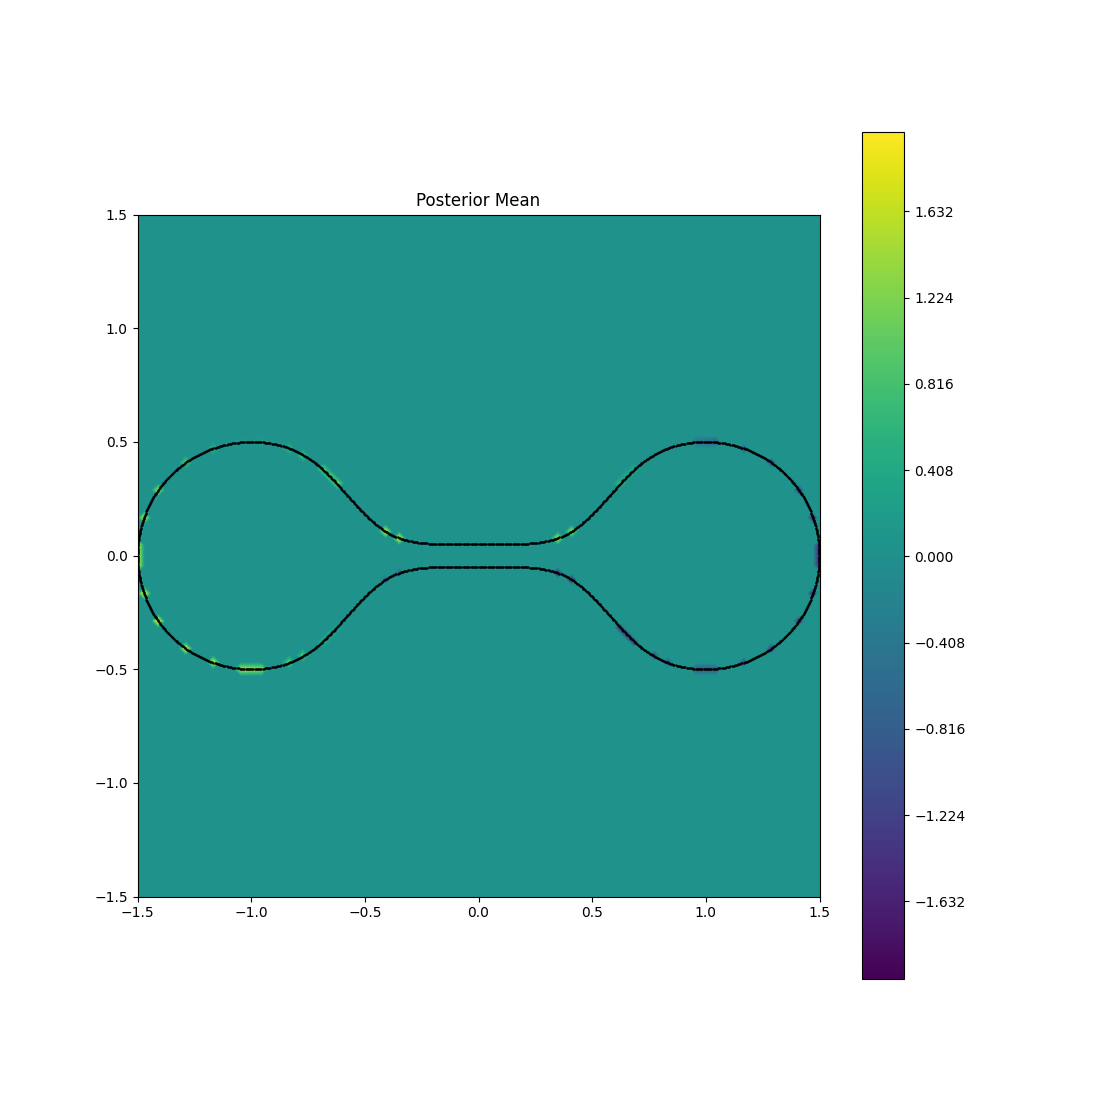

In [20]:
with torch.no_grad():
    if normalize_labels:
        posterior_mean_ambient = preds_ambient.mean.mul(std_y).add(mu_y).cpu().numpy()
    else:
        posterior_mean_ambient = preds_ambient.mean.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_mean_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

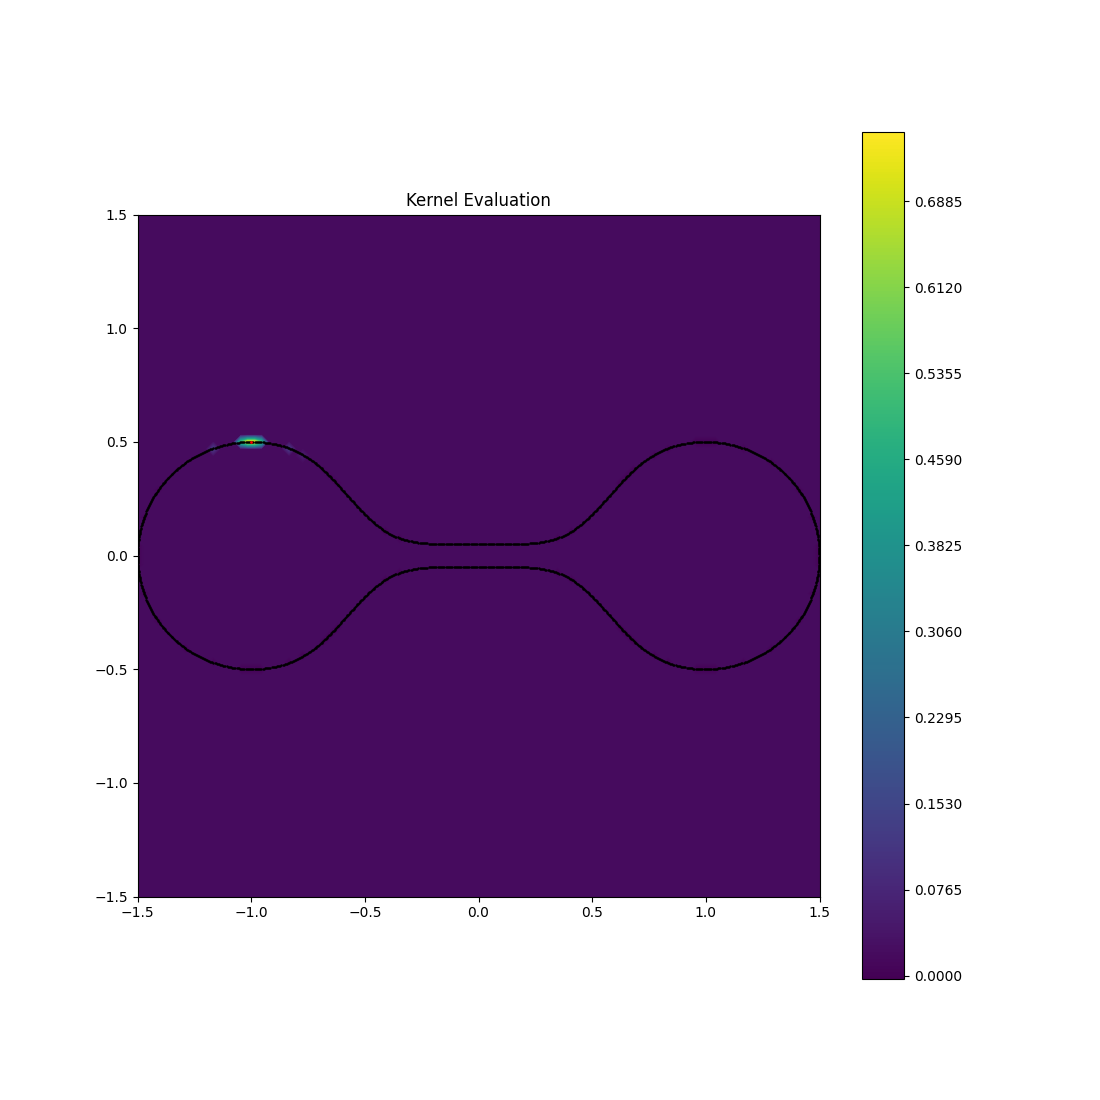

In [21]:
with torch.no_grad():
    kernel_eval_ambient = model.covar_module(noisy_x[0, :].unsqueeze(0), grid_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), kernel_eval_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=1.0)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Kernel Evaluation')

### Ambient Features

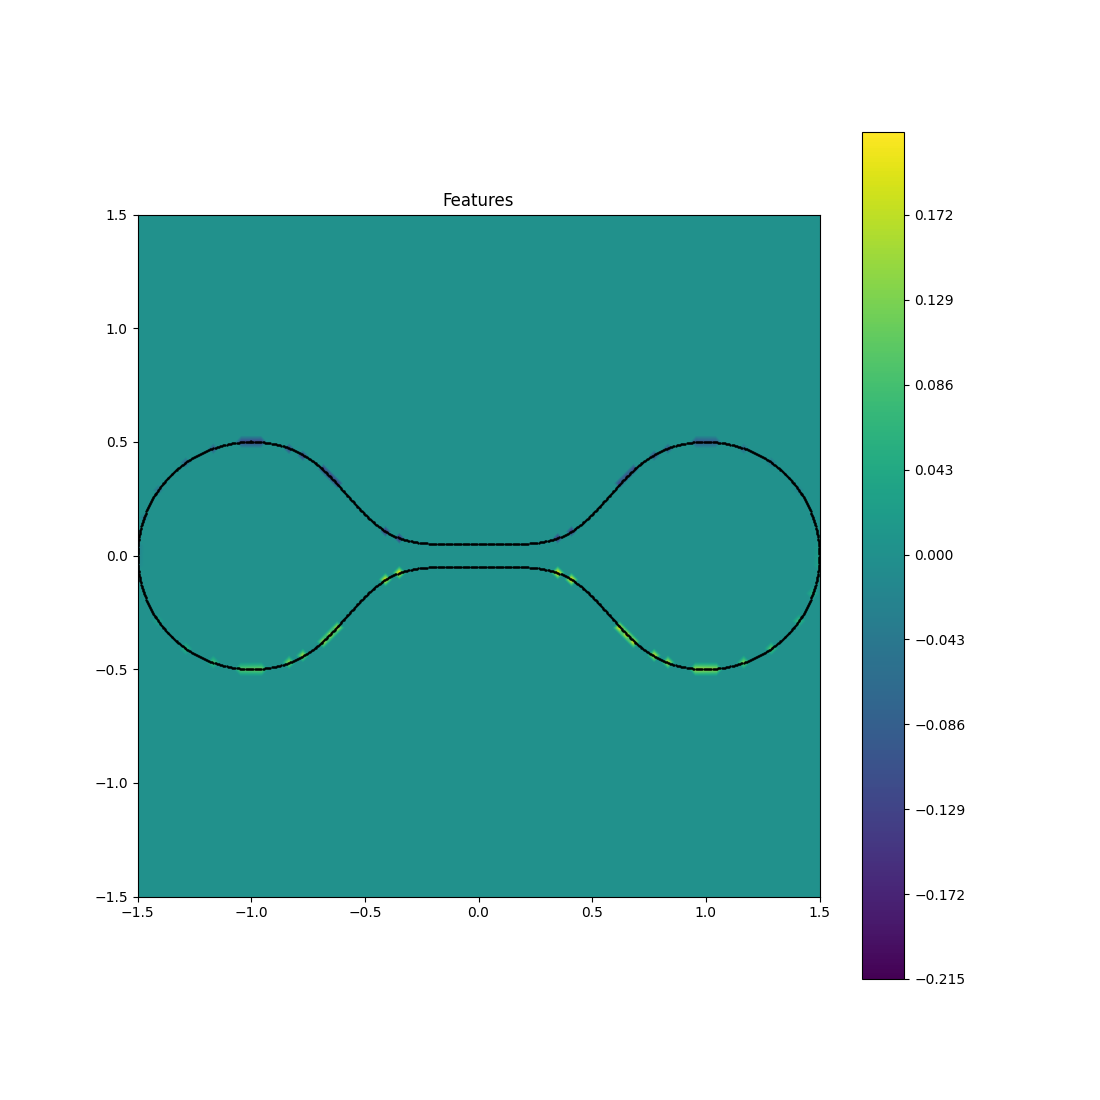

In [22]:
from torch_geometric.nn import radius

with torch.no_grad():
    test_idx, train_idx = radius(kernel.base_kernel.nodes, grid_x, c*kernel.base_kernel.epsilon, 
                                 max_num_neighbors=kernel.base_kernel.nodes.shape[0])
    c = 1.0
    features_grid = kernel.base_kernel.features(grid_x, c=c)[:,1].cpu().numpy()
#     features_grid = kernel.base_kernel.inverse_distance_weighting(grid_x, kernel.base_kernel.eigenvectors, train_idx, test_idx)[:,1].cpu().numpy()
#     features_grid = kernel.base_kernel.locally_weighted_regression(grid_x, kernel.base_kernel.eigenvectors, train_idx, test_idx, s=0.01)[:,1].cpu().numpy()
#     features_grid = kernel.base_kernel.nystrom_formula(grid_x, noisy_x, kernel.base_kernel.eigenvectors, s = 0.01)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), features_grid.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_sample_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
    ax.add_patch(circle)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Features')

### Ambient Prior Variance

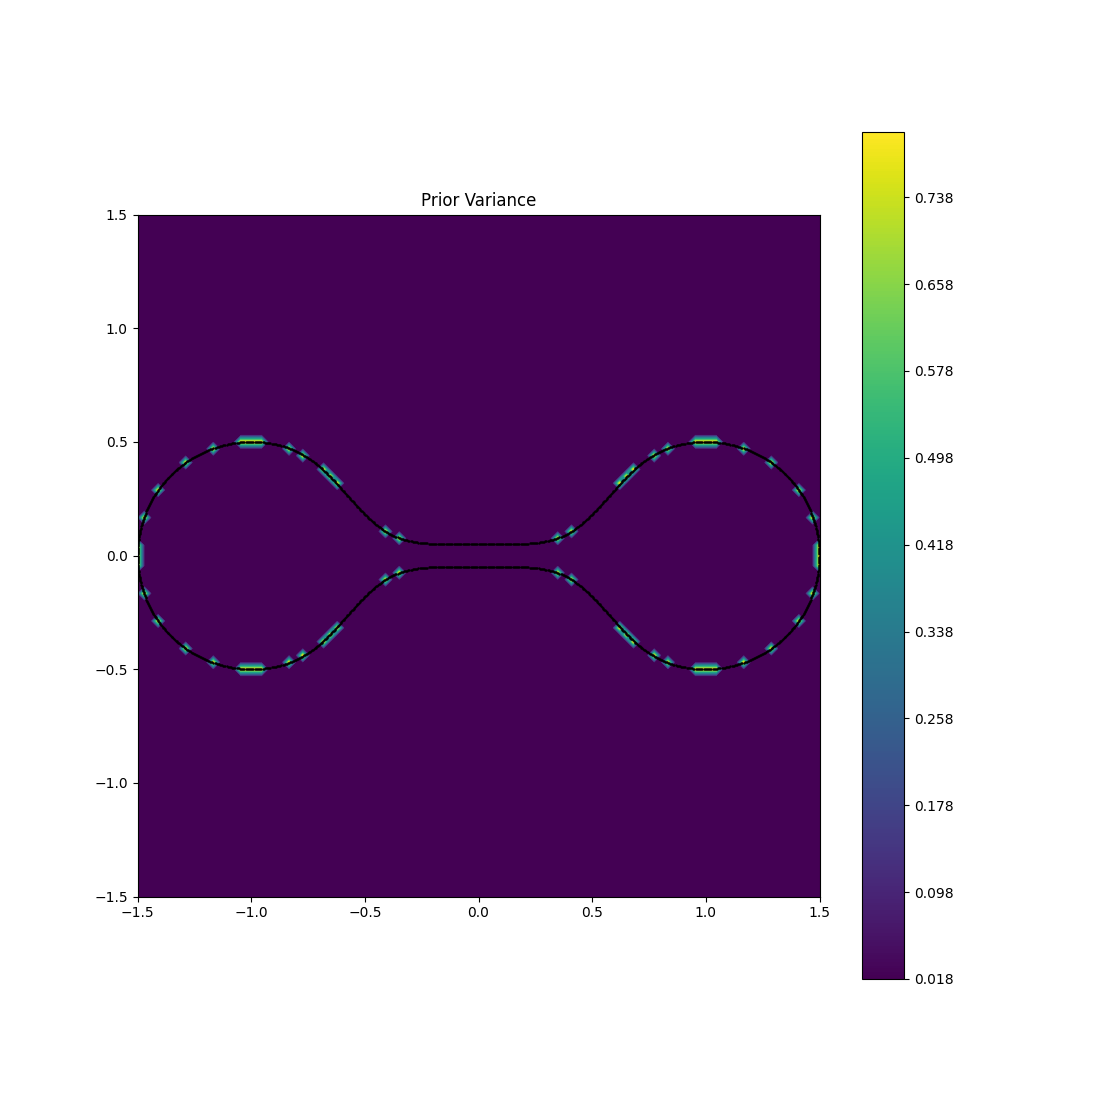

In [23]:
with torch.no_grad():
    prior_var_ambient = model.covar_module(grid_x, grid_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_var_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:276: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


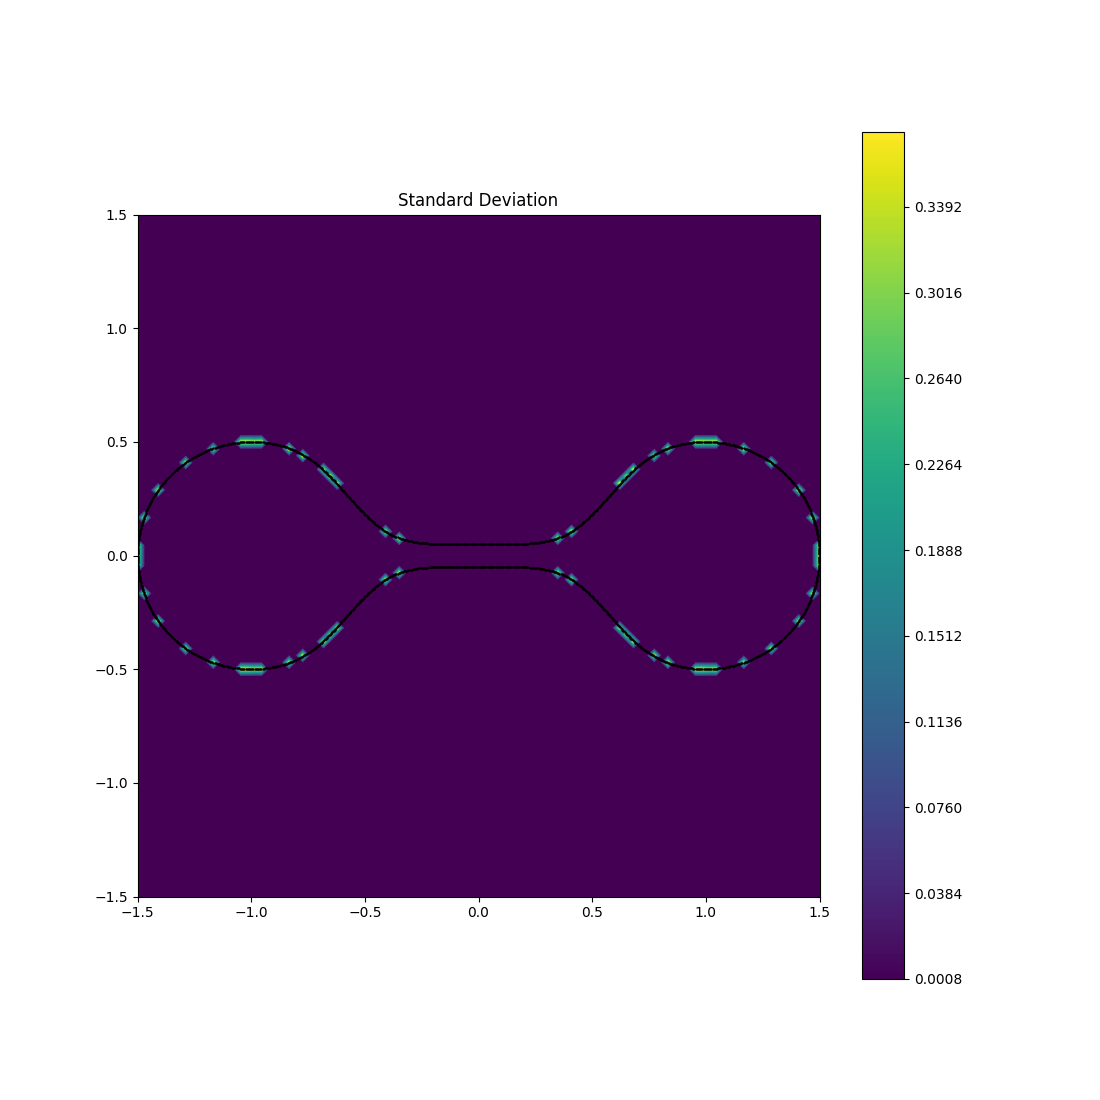

In [24]:
with torch.no_grad():
    posterior_std_ambient = preds_ambient.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Standard Deviation')